In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
# ==============================================================================
#      INTELLIGENT BATCH BENCHMARKING SCRIPT V5 (Dual FPS Measurement)
# ==============================================================================
# This version now calculates both the pure Model FPS and the overall System FPS
# to show the impact of file I/O (loading/saving).
# ==============================================================================

# ==============================================================================
#                          1. CONFIGURATION
# ==============================================================================
MODEL_TO_TEST = 'STUDENT'
DEMO_MODE_THRESHOLD_PIXELS = 500000

# ==============================================================================
#                          2. IMPORTS & SETUP
# ==============================================================================
import os
import io
import zipfile
import time
from glob import glob
from collections import OrderedDict
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from google.colab import files
from torchvision import transforms

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DOWNSCALE_FACTOR = 4

# ==============================================================================
#                         3. ALL MODEL DEFINITIONS
# ==============================================================================
# (Model definitions are the same, so they are collapsed for brevity)
class Teacher_UNet_Wider(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=96):
        super(Teacher_UNet_Wider,self).__init__();self.down1=nn.Sequential(nn.Conv2d(in_channels,features,3,1,1),nn.ReLU(inplace=True),nn.Conv2d(features,features,3,1,1),nn.ReLU(inplace=True));self.pool1=nn.MaxPool2d(2,2);self.bottleneck=nn.Sequential(nn.Conv2d(features,features*2,3,1,1),nn.ReLU(inplace=True),nn.Conv2d(features*2,features*2,3,1,1),nn.ReLU(inplace=True));self.up_conv1=nn.ConvTranspose2d(features*2,features,2,2);self.decoder1=nn.Sequential(nn.Conv2d(features*2,features,3,1,1),nn.ReLU(inplace=True),nn.Conv2d(features,features,3,1,1),nn.ReLU(inplace=True));self.final_conv=nn.Conv2d(features,out_channels,1,1,0)
    def forward(self,x):
        d1=self.down1(x);p1=self.pool1(d1);b=self.bottleneck(p1);u1=self.up_conv1(b);skip=torch.cat([u1,d1],dim=1);dec1=self.decoder1(skip);residual_output=torch.tanh(self.final_conv(dec1));return residual_output,{'bottleneck':b}
class ResidualDenseBlock(nn.Module):
    def __init__(self, nf=32, gc=16):
        super(ResidualDenseBlock,self).__init__();self.conv1=nn.Conv2d(nf,gc,3,1,1);self.conv2=nn.Conv2d(nf+gc,gc,3,1,1);self.conv3=nn.Conv2d(nf+2*gc,gc,3,1,1);self.conv4=nn.Conv2d(nf+3*gc,gc,3,1,1);self.conv5=nn.Conv2d(nf+4*gc,nf,3,1,1);self.lrelu=nn.LeakyReLU(negative_slope=0.2,inplace=True)
    def forward(self,x):
        x1=self.lrelu(self.conv1(x));x2=self.lrelu(self.conv2(torch.cat((x,x1),1)));x3=self.lrelu(self.conv3(torch.cat((x,x1,x2),1)));x4=self.lrelu(self.conv4(torch.cat((x,x1,x2,x3),1)));x5=self.conv5(torch.cat((x,x1,x2,x3,x4),1));return x5*0.2+x
class RRDB(nn.Module):
    def __init__(self,nf,gc=16):
        super(RRDB,self).__init__();self.RDB1=ResidualDenseBlock(nf,gc);self.RDB2=ResidualDenseBlock(nf,gc);self.RDB3=ResidualDenseBlock(nf,gc)
    def forward(self,x):
        out=self.RDB1(x);out=self.RDB2(out);out=self.RDB3(out);return out*0.2+x
class RRDBNet_v9(nn.Module):
    def __init__(self,in_nc=3,out_nc=3,nf=32,nb=4,gc=16,upscale=4):
        super(RRDBNet_v9,self).__init__();self.conv_first=nn.Conv2d(in_nc,nf,3,1,1);self.body=nn.Sequential(*[RRDB(nf,gc=gc) for _ in range(nb)]);self.conv_body=nn.Conv2d(nf,nf,3,1,1);self.upsampler=nn.Sequential(nn.Upsample(scale_factor=2,mode='nearest'),nn.Conv2d(nf,nf,3,1,1),nn.LeakyReLU(0.2,inplace=True),nn.Upsample(scale_factor=2,mode='nearest'),nn.Conv2d(nf,nf,3,1,1),nn.LeakyReLU(0.2,inplace=True));self.conv_hr=nn.Conv2d(nf,nf,3,1,1);self.conv_last=nn.Conv2d(nf,out_nc,3,1,1);self.lrelu=nn.LeakyReLU(negative_slope=0.2,inplace=True)
    def forward(self,x):
        fea=self.conv_first(x);trunk=self.conv_body(self.body(fea));fea=fea+trunk;fea=self.upsampler(fea);fea=self.lrelu(self.conv_hr(fea));out=self.conv_last(fea);return torch.sigmoid(out)

# ==============================================================================
#                          4. MAIN EXECUTION
# ==============================================================================
def main():
    # ... (Setup code is the same) ...
    print(f"--- INTELLIGENT BATCH PROCESSING FOR {MODEL_TO_TEST} MODEL ---")
    OUTPUT_DIR = f'/content/{MODEL_TO_TEST.lower()}_auto_results/'
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    if MODEL_TO_TEST == 'STUDENT': model = RRDBNet_v9(nf=32, nb=4, gc=16, upscale=DOWNSCALE_FACTOR).to(DEVICE)
    else: model = Teacher_UNet_Wider(features=96).to(DEVICE)
    print(f"\n--- Step 1: Upload {MODEL_TO_TEST} Model ---"); uploaded_model_file = files.upload()
    if not uploaded_model_file: return
    try:
        state_dict = torch.load(io.BytesIO(list(uploaded_model_file.values())[0]), map_location=DEVICE)
        new_state_dict = OrderedDict([(k[7:] if k.startswith('module.') else k, v) for k, v in state_dict.items()]); model.load_state_dict(new_state_dict); model.eval()
        print(f"✅ {MODEL_TO_TEST} model loaded successfully.")
    except Exception as e: print(f"❌ FATAL ERROR loading model: {e}"); return
    print("\n--- Step 2: Dataset Upload ---"); print("Please upload your .zip file containing 'student_lr' and 'hr' folders."); uploaded_zip = files.upload()
    if not uploaded_zip: return
    extract_path = '/content/temp_dataset'; zipfile.ZipFile(io.BytesIO(list(uploaded_zip.values())[0]), 'r').extractall(extract_path)
    base_lr_dir = None; base_hr_dir = None
    for root, dirs, _ in os.walk(extract_path):
        for d in dirs:
            if d.lower() == 'student_lr': base_lr_dir = os.path.join(root, d)
            if d.lower() == 'hr': base_hr_dir = os.path.join(root, d)
        if base_lr_dir and base_hr_dir: break
    if not base_lr_dir or not base_hr_dir: print("❌ Search failed."); return
    lr_image_paths = sorted(glob(os.path.join(base_lr_dir, '**', '*.*'), recursive=True)); lr_image_paths = [f for f in lr_image_paths if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    if not lr_image_paths: print("❌ No images found."); return
    print(f"✅ Found {len(lr_image_paths)} images to process.")

    # --- Step 3: Process all images ---
    all_ssim_scores, all_inference_times = [], []
    all_loop_times = []  # <-- NEW! List to store total loop times.
    demo_mode_count, enhance_mode_count = 0, 0
    ssim_metric = SSIM(data_range=1.0).to(DEVICE)
    to_tensor = transforms.ToTensor()
    to_pil = transforms.ToPILImage()

    print(f"\n--- Step 3: Processing images with Auto-Detection Logic ---")
    for lr_path in tqdm(lr_image_paths):
        try:
            loop_start_time = time.time() # <-- NEW! Start timer for the whole loop.

            hr_path = lr_path.replace(base_lr_dir, base_hr_dir)
            if not os.path.exists(hr_path):
                print(f"Warning: No matching HR image found for {os.path.basename(lr_path)}. Skipping.")
                continue

            base_filename = os.path.basename(lr_path)
            lr_pil = Image.open(lr_path).convert("RGB")
            hr_pil = Image.open(hr_path).convert("RGB")
            w, h = lr_pil.size
            is_large_blurry_image = (w * h) > DEMO_MODE_THRESHOLD_PIXELS

            if is_large_blurry_image:
                demo_mode_count += 1
                input_for_model_pil = lr_pil.resize((w // DOWNSCALE_FACTOR, h // DOWNSCALE_FACTOR), Image.BICUBIC)
            else:
                enhance_mode_count += 1
                input_for_model_pil = lr_pil

            if MODEL_TO_TEST == 'TEACHER':
                input_tensor_for_model = to_tensor(input_for_model_pil.resize(hr_pil.size, Image.BICUBIC)).unsqueeze(0).to(DEVICE)
            else: # STUDENT
                input_tensor_for_model = to_tensor(input_for_model_pil).unsqueeze(0).to(DEVICE)

            # --- This inner timer measures ONLY the model's computation ---
            inference_start_time = time.time()
            with torch.no_grad():
                if MODEL_TO_TEST == 'STUDENT':
                    output_tensor = model(input_tensor_for_model)
                else: # TEACHER
                    teacher_residual, _ = model(input_tensor_for_model)
                    output_tensor = (input_tensor_for_model + teacher_residual)
            proc_time = time.time() - inference_start_time
            all_inference_times.append(proc_time)

            enhanced_pil = to_pil(output_tensor.clamp(0, 1).squeeze(0).cpu())
            input_for_model_pil.save(os.path.join(OUTPUT_DIR, f"lr_input_{base_filename}"))
            enhanced_pil.save(os.path.join(OUTPUT_DIR, f"enhanced_{base_filename}"))

            hr_pil_resized = hr_pil.resize(enhanced_pil.size, Image.BICUBIC)
            hr_tensor = to_tensor(hr_pil_resized).unsqueeze(0).to(DEVICE)
            ssim_score = ssim_metric(output_tensor.clamp(0, 1), hr_tensor)
            all_ssim_scores.append(ssim_score.item())

            # --- Stop the outer timer and record the total loop duration ---
            loop_proc_time = time.time() - loop_start_time # <-- NEW!
            all_loop_times.append(loop_proc_time) # <-- NEW!

        except Exception as e:
            print(f"Skipping {base_filename} due to an error: {e}")

    # --- Step 4: Final Report ---
    if all_inference_times:
        # Model-specific calculations
        avg_inference_time = np.mean(all_inference_times)
        avg_model_fps = 1.0 / avg_inference_time

        # <-- NEW! System-level calculations -->
        avg_loop_time = np.mean(all_loop_times)
        avg_system_fps = 1.0 / avg_loop_time

        avg_ssim = np.mean(all_ssim_scores)

        print("\n" + "="*60)
        print(f"        {MODEL_TO_TEST} MODEL - AUTO-DETECT BENCHMARK REPORT")
        print("="*60)
        print(f"Total Images Processed:        {len(all_inference_times)}")
        print(f" - 'Demo' Mode (Shrink First): {demo_mode_count} images")
        print(f" - 'Enhance' Mode (Direct):    {enhance_mode_count} images")
        print("-" * 60)
        print("--- Model Performance (Pure Computation) ---")
        print(f"Average Model Inference Time:  {avg_inference_time:.4f} seconds/image")
        print(f"Average Model FPS:             {avg_model_fps:.2f}")
        print("-" * 60)
        print("--- System Performance (includes File I/O) ---")
        print(f"Average Total Time per Image:  {avg_loop_time:.4f} seconds/image")
        print(f"Average System Throughput:     {avg_system_fps:.2f} FPS")
        print("-" * 60)
        print(f"Average SSIM Score (All):      {avg_ssim:.4f}")
        print(f"\n✅ All enhanced outputs and their corresponding inputs saved to: {OUTPUT_DIR}")
        print("="*60)

# --- Run the main function ---
if __name__ == "__main__":
    main()

--- INTELLIGENT BATCH PROCESSING FOR STUDENT MODEL ---

--- Step 1: Upload STUDENT Model ---


Saving best_v9_RRDB_model.pth to best_v9_RRDB_model.pth
✅ STUDENT model loaded successfully.

--- Step 2: Dataset Upload ---
Please upload your .zip file containing 'student_lr' and 'hr' folders.


Saving finaltest_KD.zip to finaltest_KD.zip
✅ Found 86 images to process.

--- Step 3: Processing images with Auto-Detection Logic ---


  0%|          | 0/86 [00:00<?, ?it/s]


        STUDENT MODEL - AUTO-DETECT BENCHMARK REPORT
Total Images Processed:        86
 - 'Demo' Mode (Shrink First): 21 images
 - 'Enhance' Mode (Direct):    65 images
------------------------------------------------------------
--- Model Performance (Pure Computation) ---
Average Model Inference Time:  0.0171 seconds/image
Average Model FPS:             58.48
------------------------------------------------------------
--- System Performance (includes File I/O) ---
Average Total Time per Image:  0.8601 seconds/image
Average System Throughput:     1.16 FPS
------------------------------------------------------------
Average SSIM Score (All):      0.8782

✅ All enhanced outputs and their corresponding inputs saved to: /content/student_auto_results/


for student model test on the cpu below and above is using gpu.

In [ ]:
# ==============================================================================
#                      CELL 1: INSTALL DEPENDENCIES
# ==============================================================================
# This cell installs the required libraries for the PyTorch benchmark.

%pip install -q scikit-image matplotlib tqdm

print("✅ All necessary libraries have been installed.")

✅ All necessary libraries have been installed.


In [ ]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

✅ Libraries loaded.
--- Running PyTorch Benchmark on CPU ---

--- Step 1: Upload your PyTorch model (.pth) ---


Saving best_v9_RRDB_model.pth to best_v9_RRDB_model.pth
✅ PyTorch model loaded successfully onto CPU.

--- Step 2: Upload your benchmark dataset .zip (with hr and student_lr) ---


Saving finaltest_KD.zip to finaltest_KD.zip
✅ Found 86 images. Starting benchmark...


Benchmarking PyTorch on CPU:   0%|          | 0/86 [00:00<?, ?it/s]


📊 PYTORCH CPU BENCHMARK (UN-OPTIMIZED) - FINAL REPORT 📊
Average SSIM: 0.8937 (Std Dev: 0.0859)
Average PSNR: 26.89 dB (Std Dev: 2.91)
------------------------------------------------------------
--- Performance Analysis ---
Average Model FPS (Pure Computation): 0.05 FPS
Average System Throughput (w/ File I/O): 0.05 FPS


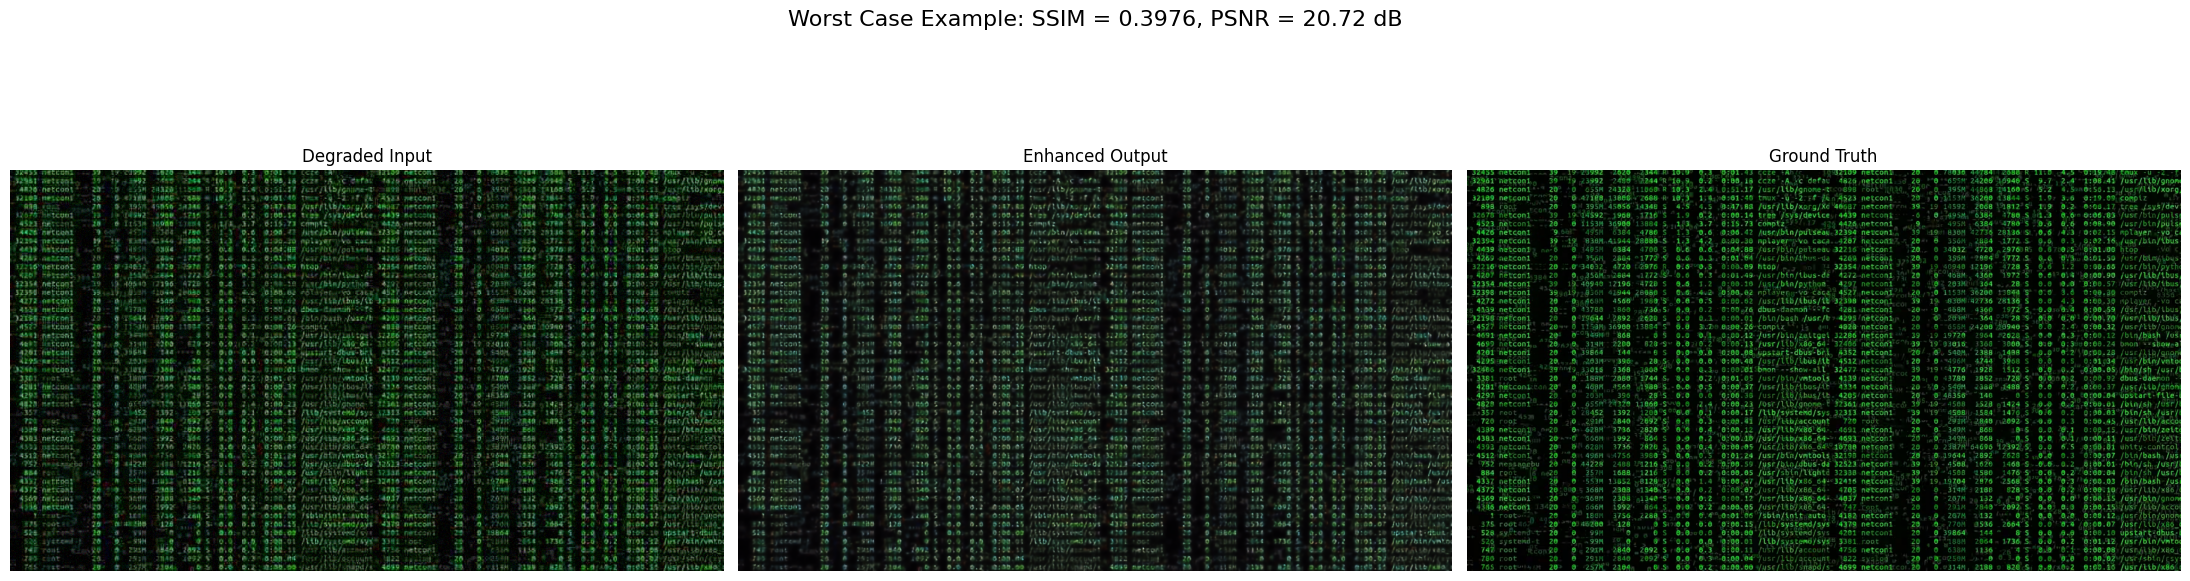

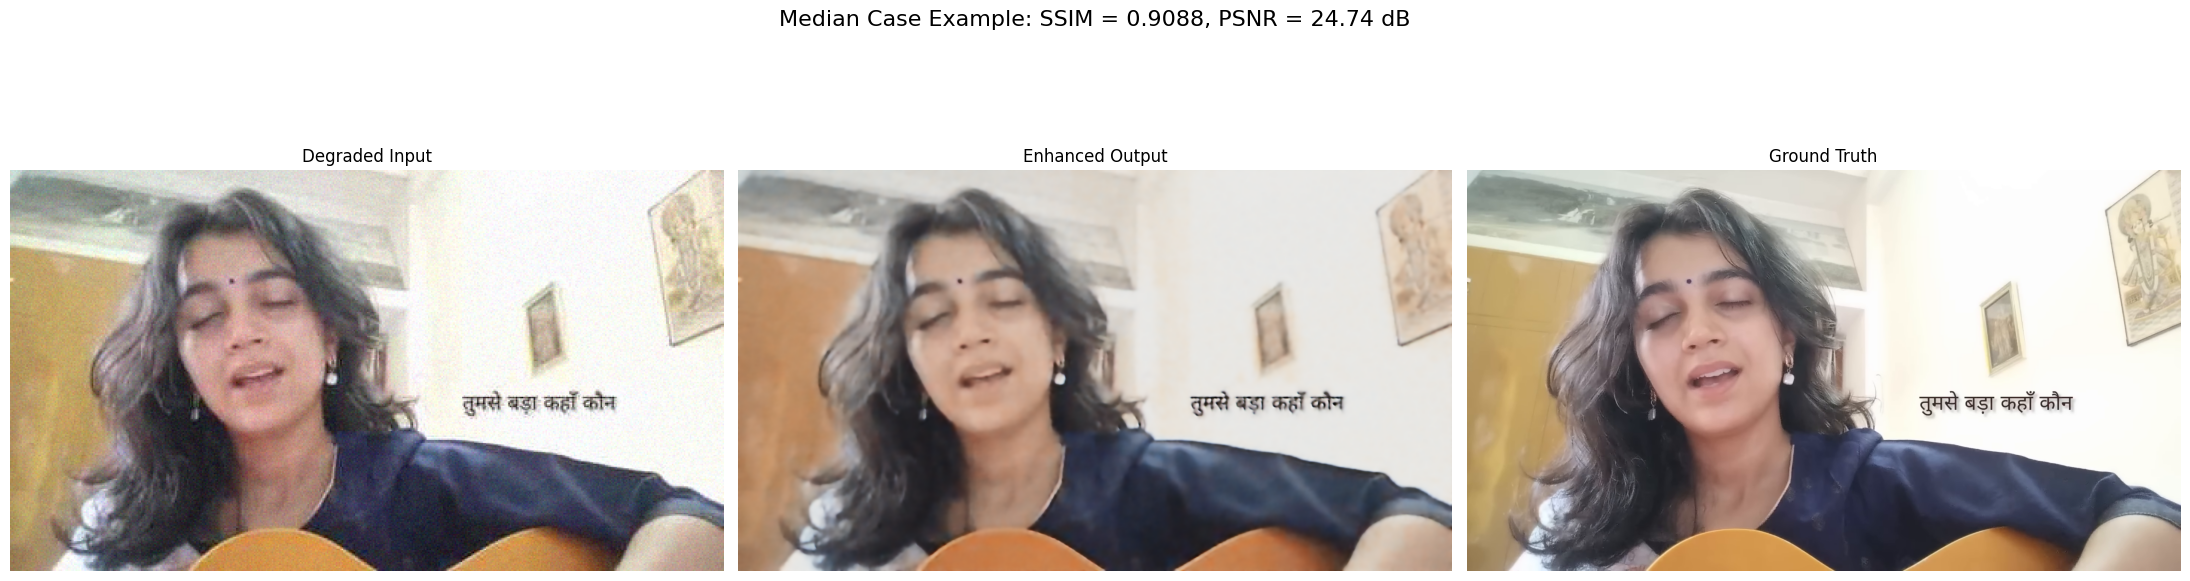

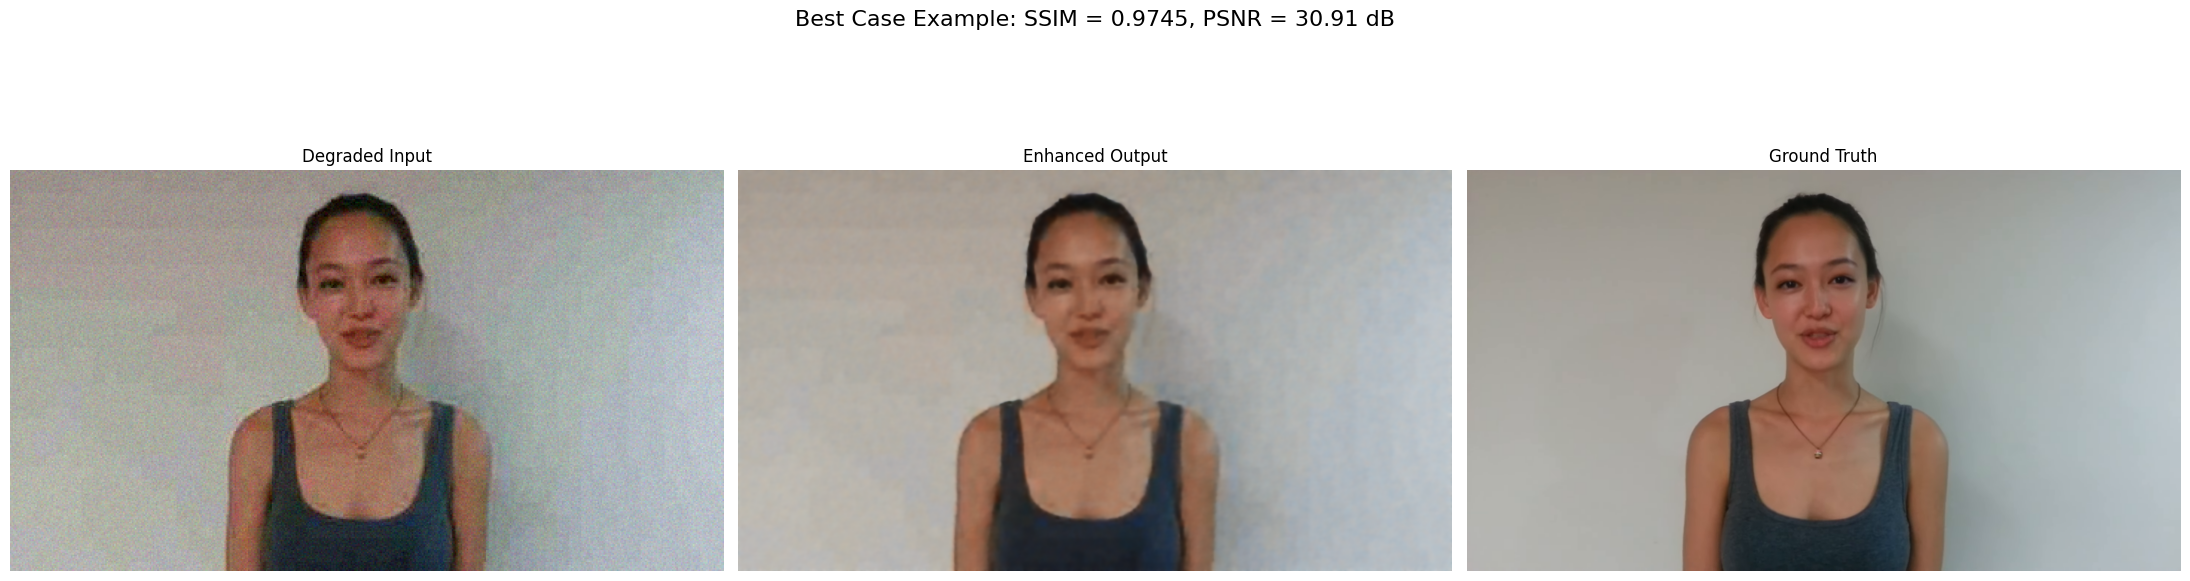


✅ Visual reports saved to '/content/cpu_pytorch_benchmark_outputs/'.


In [ ]:
# ==============================================================================
#      PYTORCH CPU BENCHMARK SCRIPT (Un-optimized Model)
# ==============================================================================
# This script provides a baseline performance evaluation of the original
# PyTorch model running on a CPU, calculating both Model and System FPS.
# ==============================================================================

# ------------------------------------------------------------------------------
# 1. SETUP & IMPORTS
# ------------------------------------------------------------------------------
import os
import time
import random
import io
import zipfile
from glob import glob
from collections import OrderedDict

import torch
import torch.nn as nn
from torchvision import transforms
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from google.colab import files

try:
    from skimage.metrics import structural_similarity as ssim
    from skimage.metrics import peak_signal_noise_ratio as psnr
except ImportError:
    print("❌ ERROR: scikit-image is not installed. Please run the installation cell again.")
    exit()

print("✅ Libraries loaded.")

# ------------------------------------------------------------------------------
# 2. MODEL ARCHITECTURE DEFINITION
# ------------------------------------------------------------------------------
class RRDBNet_v9(nn.Module):
    def __init__(self, in_nc=3, out_nc=3, nf=32, nb=4, gc=16, upscale=4):
        super(RRDBNet_v9, self).__init__(); self.upscale=upscale; self.conv_first=nn.Conv2d(in_nc,nf,3,1,1); self.body=nn.Sequential(*[RRDB(nf,gc=gc) for _ in range(nb)]); self.conv_body=nn.Conv2d(nf,nf,3,1,1); self.upsampler=nn.Sequential(nn.Upsample(scale_factor=2,mode='nearest'),nn.Conv2d(nf,nf,3,1,1),nn.LeakyReLU(0.2,inplace=True),nn.Upsample(scale_factor=2,mode='nearest'),nn.Conv2d(nf,nf,3,1,1),nn.LeakyReLU(0.2,inplace=True)); self.conv_hr=nn.Conv2d(nf,nf,3,1,1); self.conv_last=nn.Conv2d(nf,out_nc,3,1,1); self.lrelu=nn.LeakyReLU(negative_slope=0.2,inplace=True)
    def forward(self, x): fea=self.conv_first(x); trunk=self.conv_body(self.body(fea)); fea=fea+trunk; fea=self.upsampler(fea); fea=self.lrelu(self.conv_hr(fea)); out=self.conv_last(fea); return torch.sigmoid(out)
class RRDB(nn.Module):
    def __init__(self, nf, gc=16): super(RRDB,self).__init__(); self.RDB1=ResidualDenseBlock(nf,gc); self.RDB2=ResidualDenseBlock(nf,gc); self.RDB3=ResidualDenseBlock(nf,gc)
    def forward(self, x): out=self.RDB1(x); out=self.RDB2(out); out=self.RDB3(out); return out*0.2+x
class ResidualDenseBlock(nn.Module):
    def __init__(self, nf=32, gc=16): super(ResidualDenseBlock,self).__init__(); self.conv1=nn.Conv2d(nf,gc,3,1,1); self.conv2=nn.Conv2d(nf+gc,gc,3,1,1); self.conv3=nn.Conv2d(nf+2*gc,gc,3,1,1); self.conv4=nn.Conv2d(nf+3*gc,gc,3,1,1); self.conv5=nn.Conv2d(nf+4*gc,nf,3,1,1); self.lrelu=nn.LeakyReLU(negative_slope=0.2,inplace=True)
    def forward(self, x): x1=self.lrelu(self.conv1(x)); x2=self.lrelu(self.conv2(torch.cat((x,x1),1))); x3=self.lrelu(self.conv3(torch.cat((x,x1,x2),1))); x4=self.lrelu(self.conv4(torch.cat((x,x1,x2,x3),1))); x5=self.conv5(torch.cat((x,x1,x2,x3,x4),1)); return x5*0.2+x

# ------------------------------------------------------------------------------
# 3. HELPER FUNCTIONS
# ------------------------------------------------------------------------------
DOWNSCALE_FACTOR = 4

def display_graphical_report(title, results_data):
    # This is just the plotting part, collapsed for brevity
    OUTPUT_DIR = '/content/cpu_pytorch_benchmark_outputs/'; os.makedirs(OUTPUT_DIR, exist_ok=True)
    results_data.sort(key=lambda x: x['ssim'])
    worst_case, best_case, median_case = results_data[0], results_data[-1], results_data[len(results_data)//2]
    for case_type, case_data in [("Worst Case", worst_case), ("Median Case", median_case), ("Best Case", best_case)]:
        fig, ax = plt.subplots(1, 3, figsize=(22, 7)); fig.suptitle(f"{case_type} Example: SSIM = {case_data['ssim']:.4f}, PSNR = {case_data['psnr']:.2f} dB", fontsize=16)
        ax[0].imshow(case_data['degraded_pil']); ax[0].set_title('Degraded Input'); ax[0].axis('off')
        ax[1].imshow(case_data['enhanced_pil']); ax[1].set_title('Enhanced Output'); ax[1].axis('off')
        ax[2].imshow(case_data['original_pil']); ax[2].set_title('Ground Truth'); ax[2].axis('off')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
        fig.savefig(os.path.join(OUTPUT_DIR, f"comparison_{case_type.replace(' ', '_').lower()}.png"))
    print(f"\n✅ Visual reports saved to '{OUTPUT_DIR}'.")


# ------------------------------------------------------------------------------
# 4. MAIN EXECUTION BLOCK
# ------------------------------------------------------------------------------
def main():
    DEVICE = torch.device("cpu")
    print(f"--- Running PyTorch Benchmark on {str(DEVICE).upper()} ---")

    # --- Step 1: Upload and Load PyTorch Model ---
    print("\n--- Step 1: Upload your PyTorch model (.pth) ---")
    uploaded_model = files.upload()
    if not uploaded_model: return
    model = RRDBNet_v9().to(DEVICE)
    try:
        state_dict = torch.load(io.BytesIO(list(uploaded_model.values())[0]), map_location=DEVICE)
        new_state_dict = OrderedDict([(k[7:] if k.startswith('module.') else k, v) for k, v in state_dict.items()])
        model.load_state_dict(new_state_dict); model.eval()
        print("✅ PyTorch model loaded successfully onto CPU.")
    except Exception as e: print(f"❌ Error loading model: {e}"); return

    # --- Step 2: Upload and Find Data ---
    print("\n--- Step 2: Upload your benchmark dataset .zip (with hr and student_lr) ---")
    uploaded_data = files.upload()
    if not uploaded_data: return
    data_extract_path = '/content/benchmark_data/'
    with zipfile.ZipFile(io.BytesIO(list(uploaded_data.values())[0]), 'r') as z: z.extractall(data_extract_path)
    base_hr_dir = None; base_lr_dir = None
    for root, dirs, _ in os.walk(data_extract_path):
        for d in dirs:
            if d.lower() == 'hr': base_hr_dir = os.path.join(root, d)
            if d.lower() == 'student_lr': base_lr_dir = os.path.join(root, d)
        if base_hr_dir and base_lr_dir: break
    if not base_hr_dir or not base_lr_dir: print("❌ Could not find folders."); return
    lr_image_paths = sorted(glob(os.path.join(base_lr_dir, '**', '*.*'), recursive=True))
    lr_image_paths = [f for f in lr_image_paths if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"✅ Found {len(lr_image_paths)} images. Starting benchmark...")

    # --- Step 3: Run the Benchmark Loop with DUAL TIMERS ---
    results_data, total_loop_time, total_inference_time = [], 0, 0
    to_tensor = transforms.ToTensor(); to_pil = transforms.ToPILImage()
    for lr_path in tqdm(lr_image_paths, desc="Benchmarking PyTorch on CPU"):
        loop_start_time = time.time()
        hr_path = lr_path.replace(base_lr_dir, base_hr_dir)
        if not os.path.exists(hr_path): continue

        original_pil = Image.open(hr_path).convert("RGB")
        degraded_pil = Image.open(lr_path).convert("RGB")

        # --- Timed Inference Block ---
        inference_start_time = time.time()
        input_tensor = to_tensor(degraded_pil).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            output_tensor = model(input_tensor)
        enhanced_pil = to_pil(output_tensor.squeeze(0).cpu())
        total_inference_time += time.time() - inference_start_time

        total_loop_time += time.time() - loop_start_time

        original_np, enhanced_np = np.array(original_pil), np.array(enhanced_pil)
        h,w,_ = enhanced_np.shape; original_cropped_np = original_np[:h,:w,:]
        results_data.append({
            "ssim": ssim(original_cropped_np, enhanced_np, data_range=255, channel_axis=-1, win_size=7),
            "psnr": psnr(original_cropped_np, enhanced_np, data_range=255),
            "original_pil": original_pil, "degraded_pil": degraded_pil, "enhanced_pil": enhanced_pil
        })

    # --- Step 4: Display the final report ---
    if results_data:
        avg_model_fps = len(results_data) / total_inference_time if total_inference_time > 0 else 0
        avg_system_fps = len(results_data) / total_loop_time if total_loop_time > 0 else 0
        avg_ssim = np.mean([r['ssim'] for r in results_data]); std_ssim = np.std([r['ssim'] for r in results_data])
        avg_psnr = np.mean([r['psnr'] for r in results_data]); std_psnr = np.std([r['psnr'] for r in results_data])

        print("\n" + "="*60)
        print("📊 PYTORCH CPU BENCHMARK (UN-OPTIMIZED) - FINAL REPORT 📊")
        print("="*60)
        print(f"Average SSIM: {avg_ssim:.4f} (Std Dev: {std_ssim:.4f})")
        print(f"Average PSNR: {avg_psnr:.2f} dB (Std Dev: {std_psnr:.2f})")
        print("-" * 60)
        print("--- Performance Analysis ---")
        print(f"Average Model FPS (Pure Computation): {avg_model_fps:.2f} FPS")
        print(f"Average System Throughput (w/ File I/O): {avg_system_fps:.2f} FPS")
        print("="*60)

        display_graphical_report("PyTorch CPU Benchmark", results_data)

# --- Run the main function ---
if __name__ == "__main__":
    main()